In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [ ]:
df = pd.read_csv('/content/train.csv')

In [ ]:
df.shape

(404290, 6)

In [ ]:
new_df = df.sample(30000, random_state=42).reset_index(drop=True)

In [ ]:
new_df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
9306,52198,38362,24861,What are the best ways to lose weight fast?,How can I lose weight ?,1
3789,337086,464525,464526,If a guy ejaculates in you can you taste it?,Is it wrong to be friends with a guy you know ...,0
13620,89198,149903,149904,How can I learn to approach stressful situatio...,What buisness analytics courses can I do durin...,0
16628,103554,171140,171141,What was the best Japanese drama in the early ...,What is the best book on the Japanese Lost Dec...,0
13287,183672,111681,280808,Is it possible to skip a grade in Italian high...,School: Can I skip a grade?,0


In [ ]:
new_df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [ ]:
new_df.duplicated().sum()

np.int64(0)

In [ ]:
import unicodedata

In [ ]:
    # https://stackoverflow.com/a/19794953
    contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

def expand_contractions(text: str) -> str:
      tokens = text.split()
      out = []
      for t in tokens:
          if t in contractions:
              out.append(contractions[t])
          else:
              out.append(t)
      return " ".join(out)

def semi_clean(text: str) -> str:
      if not isinstance(text, str):
          text = str(text)

      q = text.lower().strip()
      q = q.replace('%', ' percent')
      q = q.replace('$', ' dollar ')
      q = q.replace('₹', ' rupee ')
      q = q.replace('€', ' euro ')
      q = q.replace('@', ' at ')

      q = expand_contractions(q)
      q = q.replace("'ve", " have").replace("'ll", " will")
      q = q.replace("'re", " are").replace("n't", " not")

      q = unicodedata.normalize("NFKD", q)

      q = BeautifulSoup(q, "html.parser").get_text()

      q = re.sub(r"\s+", " ", q).strip()

      return q

In [ ]:
semi_clean("I've already done! haven't <b>done</b>?")

'i have already done! have not done?'

In [ ]:
new_df["q1_semi"] = new_df["question1"].apply(semi_clean)
new_df["q2_semi"] = new_df["question2"].apply(semi_clean)

In [ ]:
print(new_df[["question1", "q1_semi"]].head())
print(new_df[["question2", "q2_semi"]].head())

                                           question1  \
0                 How do I play Pokémon GO in Korea?   
1  What are some of the best side dishes for crab...   
2  Which is more advisable and better material fo...   
3       How do I improve logical programming skills?   
4             How close we are to see 3rd world war?   

                                             q1_semi  
0                how do i play pokémon go in korea?  
1  what are some of the best side dishes for crab...  
2  which is more advisable and better material fo...  
3       how do i improve logical programming skills?  
4             how close we are to see 3rd world war?  
                                           question2  \
0                 How do I play Pokémon GO in China?   
1  What are some good side dishes for buffalo chi...   
2      What is the best server setup for buddypress?   
3  How can I improve my logical skills for progra...   
4                      How close is a World War III? 

In [ ]:
all_qs_sample = pd.concat([new_df["q1_semi"], new_df["q2_semi"]], axis=0)
unique_questions = all_qs_sample.dropna().unique().tolist()
print(f"Unique questions in sample: {len(unique_questions):,}")

Unique questions in sample: 55,409


In [ ]:
import sentence_transformers
print(sentence_transformers.__version__)

4.1.0


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

all_embs = model.encode(
    unique_questions,
    batch_size=128,
    show_progress_bar=True,
    convert_to_numpy=True,
    num_workers=4
)

embeddings_dict = dict(zip(unique_questions, all_embs))
print("Finished encoding sample unique questions.")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/433 [00:00<?, ?it/s]

Finished encoding sample unique questions.


In [ ]:
import numpy as np

n_rows = new_df.shape[0]
dim = all_embs.shape[1]

q1_embs = np.zeros((n_rows, dim), dtype="float32")
q2_embs = np.zeros((n_rows, dim), dtype="float32")

for idx, row in new_df.iterrows():
    q1_embs[idx] = embeddings_dict[row["q1_semi"]]
    q2_embs[idx] = embeddings_dict[row["q2_semi"]]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse

cos_sim_array = cosine_similarity(q1_embs, q2_embs, dense_output=False).diagonal()
new_df["emb_cosine"] = cos_sim_array

In [ ]:
from sklearn.decomposition import IncrementalPCA

emb_diff = np.abs(q1_embs - q2_embs)
ipca = IncrementalPCA(n_components=50, batch_size=5000)
for i in range(0, n_rows, 5000):
    ipca.partial_fit(emb_diff[i : i + 5000])
X_diff_reduced = ipca.transform(emb_diff)
for j in range(50):
    new_df[f"emb_pc_{j}"] = X_diff_reduced[:, j]

In [ ]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_semi,q2_semi,emb_cosine,emb_pc_0,...,emb_pc_40,emb_pc_41,emb_pc_42,emb_pc_43,emb_pc_44,emb_pc_45,emb_pc_46,emb_pc_47,emb_pc_48,emb_pc_49
0,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,how do i play pokémon go in korea?,how do i play pokémon go in china?,0.804451,-0.112253,...,-0.001101,0.011185,0.001770,-0.003826,-0.007121,-0.028459,-0.018998,0.015937,-0.014038,0.015938
1,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...,0.635703,0.089606,...,0.036746,0.033925,0.031456,-0.009642,-0.037645,0.090008,0.006080,-0.017417,0.013912,0.019491
2,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,which is more advisable and better material fo...,what is the best server setup for buddypress?,0.046763,0.499319,...,0.017645,-0.026212,0.080554,0.096634,-0.007696,-0.019759,0.019935,-0.043419,0.108195,0.059081
3,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,how do i improve logical programming skills?,how can i improve my logical skills for progra...,0.979174,-0.424017,...,0.005924,-0.005164,0.013258,-0.005885,0.001172,-0.012413,0.005814,-0.004089,0.000848,0.002208
4,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,how close we are to see 3rd world war?,how close is a world war iii?,0.844631,-0.154373,...,0.039730,0.005427,0.000925,0.013526,0.007632,-0.008074,-0.007944,-0.002829,-0.005569,-0.025205


In [ ]:
def token_overlap_ratio_min(q1: str, q2: str) -> float:
    t1 = q1.split()
    t2 = q2.split()
    if not t1 or not t2:
        return 0.0
    s1, s2 = set(t1), set(t2)
    common = s1.intersection(s2)
    return len(common) / min(len(t1), len(t2))

new_df["cwc_min"] = new_df.apply(
    lambda r: token_overlap_ratio_min(r["q1_semi"], r["q2_semi"]), axis=1
)

In [ ]:
to_drop = ["id", "qid1", "qid2", "question1", "question2", "q1_semi", "q2_semi"]
df_features = new_df.drop(columns=to_drop)

y = df_features["is_duplicate"].values
feature_cols = [c for c in df_features.columns if c != "is_duplicate"]
X = df_features[feature_cols].values

print("Feature columns:", feature_cols)
print("X shape:", X.shape, "y shape:", y.shape)

Feature columns: ['emb_cosine', 'emb_pc_0', 'emb_pc_1', 'emb_pc_2', 'emb_pc_3', 'emb_pc_4', 'emb_pc_5', 'emb_pc_6', 'emb_pc_7', 'emb_pc_8', 'emb_pc_9', 'emb_pc_10', 'emb_pc_11', 'emb_pc_12', 'emb_pc_13', 'emb_pc_14', 'emb_pc_15', 'emb_pc_16', 'emb_pc_17', 'emb_pc_18', 'emb_pc_19', 'emb_pc_20', 'emb_pc_21', 'emb_pc_22', 'emb_pc_23', 'emb_pc_24', 'emb_pc_25', 'emb_pc_26', 'emb_pc_27', 'emb_pc_28', 'emb_pc_29', 'emb_pc_30', 'emb_pc_31', 'emb_pc_32', 'emb_pc_33', 'emb_pc_34', 'emb_pc_35', 'emb_pc_36', 'emb_pc_37', 'emb_pc_38', 'emb_pc_39', 'emb_pc_40', 'emb_pc_41', 'emb_pc_42', 'emb_pc_43', 'emb_pc_44', 'emb_pc_45', 'emb_pc_46', 'emb_pc_47', 'emb_pc_48', 'emb_pc_49', 'cwc_min']
X shape: (30000, 52) y shape: (30000,)


In [ ]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=1, stratify=y
)

neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
base_weight = neg_count / pos_count
print(f"Train sample has {neg_count} negatives vs. {pos_count} positives → base_weight={base_weight:.2f}")

alpha = 3.0
lgbm = LGBMClassifier(
    objective="binary",
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    class_weight={0: 1.0, 1: base_weight * alpha},
    random_state=1,
    n_jobs=-1
)
lgbm.fit(X_train, y_train)

Train sample has 15158 negatives vs. 8842 positives → base_weight=1.71
[LightGBM] [Info] Number of positive: 8842, number of negative: 15158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13180
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.750000 -> initscore=1.098612
[LightGBM] [Info] Start training from score 1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMClassifier(class_weight={0: 1.0, 1: np.float64(5.1429540827867)},
               learning_rate=0.05, max_depth=6, n_estimators=200, n_jobs=-1,
               objective='binary', random_state=1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
y_prob = lgbm.predict_proba(X_test)[:, 1]
y_pred_default = (y_prob >= 0.50).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_default).ravel()
print(f"LightGBM (20% test of 30k) @ t=0.50 → FP: {fp}, TP: {tp}, TN: {tn}, FN: {fn}")
print(classification_report(y_test, y_pred_default, digits=4))

LightGBM (20% test of 30k) @ t=0.50 → FP: 1372, TP: 2109, TN: 2417, FN: 102
              precision    recall  f1-score   support

           0     0.9595    0.6379    0.7663      3789
           1     0.6059    0.9539    0.7410      2211

    accuracy                         0.7543      6000
   macro avg     0.7827    0.7959    0.7537      6000
weighted avg     0.8292    0.7543    0.7570      6000



Threshold selected (max F1):
   0.675897
2007.000000
1069.000000
2720.000000
 204.000000
   0.652471
   0.907734
   0.759221

FINAL @ threshold = 0.68
  TP: 2007, FP: 1069, TN: 2720, FN: 204



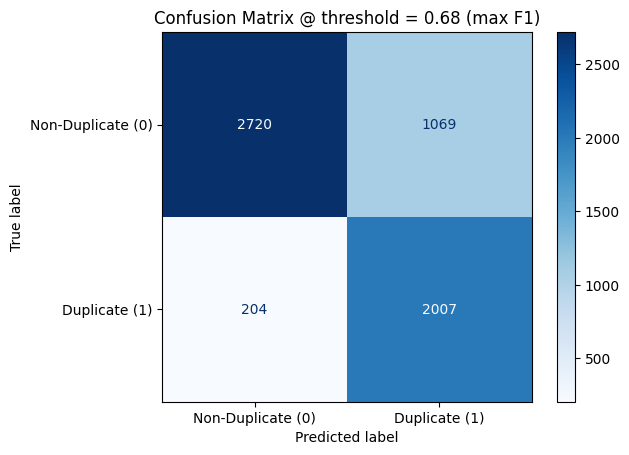

Classification Report (at chosen threshold):
              precision    recall  f1-score   support

           0     0.9302    0.7179    0.8104      3789
           1     0.6525    0.9077    0.7592      2211

    accuracy                         0.7878      6000
   macro avg     0.7914    0.8128    0.7848      6000
weighted avg     0.8279    0.7878    0.7915      6000



In [ ]:
def evaluate_thresholds(y_true, y_prob, thresholds):
    """
    For each threshold t in `thresholds`, compute:
      TP, FP, TN, FN, precision, recall, and F1‐score.
    Returns a DataFrame with one row per threshold.
    """
    records = []
    for t in thresholds:
        y_pred_t = (y_prob >= t).astype(int)
        tn_, fp_, fn_, tp_ = confusion_matrix(y_true, y_pred_t).ravel()
        precision_ = tp_ / (tp_ + fp_) if (tp_ + fp_) > 0 else 0.0
        recall_    = tp_ / (tp_ + fn_) if (tp_ + fn_) > 0 else 0.0
        f1_ = (2 * precision_ * recall_) / (precision_ + recall_) if (precision_ + recall_) > 0 else 0.0

        records.append({
            "threshold": t,
            "TP": tp_,
            "FP": fp_,
            "TN": tn_,
            "FN": fn_,
            "precision": precision_,
            "recall": recall_,
            "f1": f1_
        })
    return pd.DataFrame(records)

# ─── 3. Sweep thresholds between 0.50 and 0.99 ────────────────────────────────
thresh_grid = np.linspace(0.50, 0.99, 40)
df_thresh = evaluate_thresholds(y_test, y_prob, thresh_grid)

# ─── 4. Pick the threshold that maximizes F1 ─────────────────────────────────
best_row = df_thresh.sort_values("f1", ascending=False).iloc[0]
print("Threshold selected (max F1):")
print(best_row.to_string(index=False))

best_t = best_row["threshold"]

# ─── 5. Compute final predictions and confusion matrix at best_t ─────────────
y_pred_final = (y_prob >= best_t).astype(int)
tn_f, fp_f, fn_f, tp_f = confusion_matrix(y_test, y_pred_final).ravel()

print(f"\nFINAL @ threshold = {best_t:.2f}")
print(f"  TP: {tp_f}, FP: {fp_f}, TN: {tn_f}, FN: {fn_f}\n")

# ─── 6. Display the confusion matrix visually ───────────────────────────────
cm = confusion_matrix(y_test, y_pred_final, labels=[0, 1])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non‐Duplicate (0)", "Duplicate (1)"]
)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix @ threshold = {best_t:.2f} (max F1)")
plt.show()

# ─── 7. Print full classification report ─────────────────────────────────────
print("Classification Report (at chosen threshold):")
print(classification_report(y_test, y_pred_final, digits=4))

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00



🔍 Training and tuning: RandomForest
  → Best threshold (max F1): 0.50, F1 = 0.7263
  TP: 1649, FP: 681, TN: 3108, FN: 562


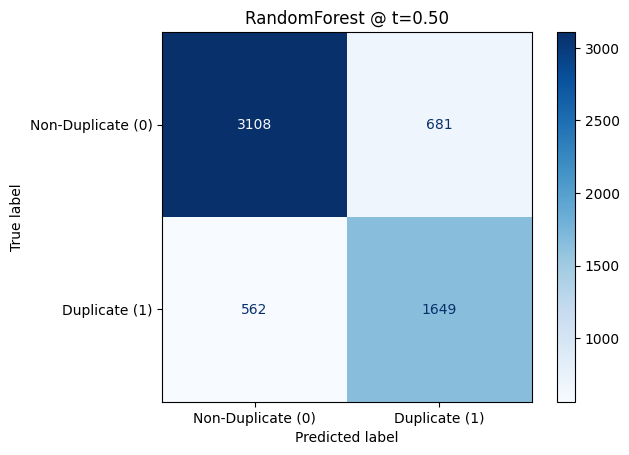

  Classification Report:
              precision    recall  f1-score   support

           0     0.8469    0.8203    0.8334      3789
           1     0.7077    0.7458    0.7263      2211

    accuracy                         0.7928      6000
   macro avg     0.7773    0.7830    0.7798      6000
weighted avg     0.7956    0.7928    0.7939      6000


🔍 Training and tuning: XGBoost
  → Best threshold (max F1): 0.50, F1 = 0.7238
  TP: 1647, FP: 693, TN: 3096, FN: 564


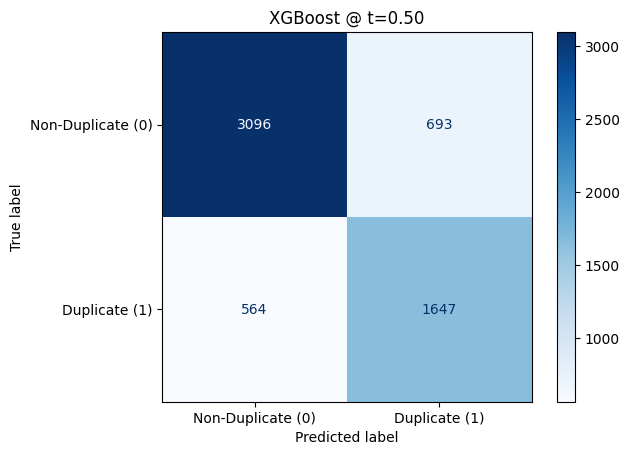

  Classification Report:
              precision    recall  f1-score   support

           0     0.8459    0.8171    0.8313      3789
           1     0.7038    0.7449    0.7238      2211

    accuracy                         0.7905      6000
   macro avg     0.7749    0.7810    0.7775      6000
weighted avg     0.7936    0.7905    0.7917      6000


🔍 Training and tuning: LogisticRegression
  → Best threshold (max F1): 0.50, F1 = 0.7091
  TP: 1610, FP: 720, TN: 3069, FN: 601


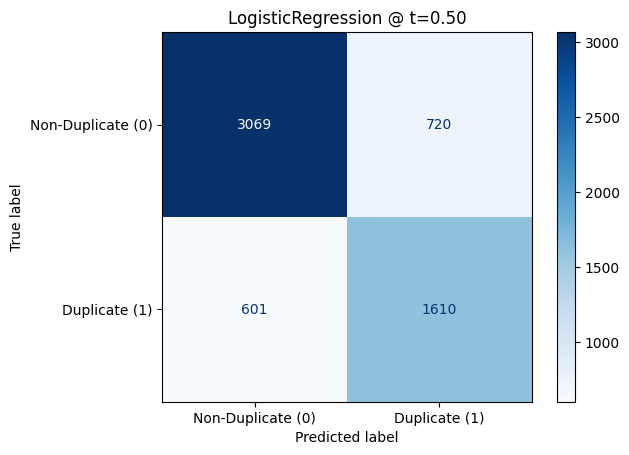

  Classification Report:
              precision    recall  f1-score   support

           0     0.8362    0.8100    0.8229      3789
           1     0.6910    0.7282    0.7091      2211

    accuracy                         0.7798      6000
   macro avg     0.7636    0.7691    0.7660      6000
weighted avg     0.7827    0.7798    0.7810      6000


🔍 Training and tuning: CatBoost
  → Best threshold (max F1): 0.50, F1 = 0.7576
  TP: 1961, FP: 1005, TN: 2784, FN: 250


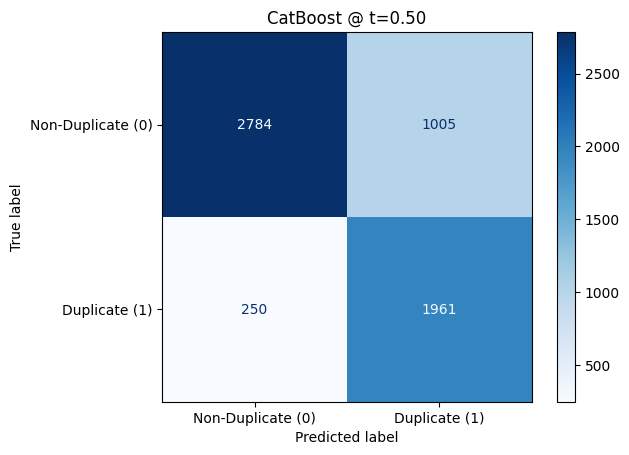

  Classification Report:
              precision    recall  f1-score   support

           0     0.9176    0.7348    0.8161      3789
           1     0.6612    0.8869    0.7576      2211

    accuracy                         0.7908      6000
   macro avg     0.7894    0.8108    0.7868      6000
weighted avg     0.8231    0.7908    0.7945      6000


=== MODEL COMPARISON (sorted by F1) ===
                model  threshold    TP    FP    TN   FN  precision    recall  \
3            CatBoost        0.5  1961  1005  2784  250   0.661160  0.886929   
0        RandomForest        0.5  1649   681  3108  562   0.707725  0.745816   
1             XGBoost        0.5  1647   693  3096  564   0.703846  0.744912   
2  LogisticRegression        0.5  1610   720  3069  601   0.690987  0.728177   

         f1  
3  0.757582  
0  0.726272  
1  0.723797  
2  0.709095  


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    "CatBoost": CatBoostClassifier(iterations=200, depth=6, learning_rate=0.05,
                                   class_weights=[1.0, (y_train == 0).sum() / (y_train == 1).sum()],
                                   verbose=False, random_seed=42)
}

def evaluate_thresholds(y_true, y_prob, thresholds):
    records = []
    for t in thresholds:
        y_pred_t = (y_prob >= t).astype(int)
        tn_, fp_, fn_, tp_ = confusion_matrix(y_true, y_pred_t).ravel()
        precision_ = tp_ / (tp_ + fp_) if (tp_ + fp_) > 0 else 0.0
        recall_    = tp_ / (tp_ + fn_) if (tp_ + fn_) > 0 else 0.0
        f1_ = (2 * precision_ * recall_) / (precision_ + recall_) if (precision_ + recall_) > 0 else 0.0
        records.append({"threshold": t, "TP": tp_, "FP": fp_, "TN": tn_, "FN": fn_,
                        "precision": precision_, "recall": recall_, "f1": f1_})
    return pd.DataFrame(records)

thresh_grid = np.linspace(0.50, 0.99, 40)

results_summary = []

for name, clf in models.items():
    print(f"\n🔍 Training and tuning: {name}")
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]

    df_thresh = evaluate_thresholds(y_test, y_prob, thresh_grid)
    best_row = df_thresh.sort_values("f1", ascending=False).iloc[0]
    best_t = best_row["threshold"]
    print(f"  → Best threshold (max F1): {best_t:.2f}, F1 = {best_row['f1']:.4f}")

    y_pred_final = (y_prob >= best_t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final).ravel()
    print(f"  TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

    cm = confusion_matrix(y_test, y_pred_final, labels=[0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["Non‐Duplicate (0)", "Duplicate (1)"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} @ t={best_t:.2f}")
    plt.show()

    print("  Classification Report:")
    print(classification_report(y_test, y_pred_final, digits=4))

    results_summary.append({
        "model": name,
        "threshold": best_t,
        "TP": tp, "FP": fp, "TN": tn, "FN": fn,
        "precision": best_row["precision"],
        "recall": best_row["recall"],
        "f1": best_row["f1"]
    })

summary_df = pd.DataFrame(results_summary).sort_values("f1", ascending=False)
print("\n=== MODEL COMPARISON (sorted by F1) ===")
print(summary_df[["model", "threshold", "TP", "FP", "TN", "FN", "precision", "recall", "f1"]])